# Sentiment Analysis

In [1]:
from dotenv import dotenv_values
import requests
import json
import tweepy

import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blancc2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
config = dotenv_values(".env")

bearer_token = config["BEARER_TOKEN"]
consumer_key = config["API_KEY"]
consumer_secret = config["API_KEY_SECRET"]

In [3]:
tweets_folder = Path("data/Tweets_Data")

In [4]:
#print(config["API_KEY"])

In [5]:
def search_agricultural_tweets(country_name, extra_term,max_results=100):
    
    #Create empty DataFrame with specific column names & types
    tweets_data = pd.DataFrame({'ID': pd.Series(dtype='int'),
                    'text': pd.Series(dtype='str')})
    
    
    client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=consumer_key, 
                        consumer_secret=consumer_secret,
                        wait_on_rate_limit=True)


    if country_name is None:
        query="((agricultural) OR (agriculture)) -NBCHAIN lang:en -is:retweet"
    else:
        query="((agricultural) OR (agriculture)) ("+country_name +" OR " + extra_term +") -NBCHAIN lang:en -is:retweet"
            
    for tweet in tweepy.Paginator(client.search_recent_tweets, 
                                    query=query, 
                                    tweet_fields=['author_id', 'created_at'],
                                     max_results=min(max_results,100)).flatten(limit=max_results):
        tweets_data=pd.concat([tweets_data, pd.DataFrame.from_records([{'ID':tweet.id,
                                'text':tweet.text}])])
    return tweets_data

In [6]:
max_results=3000
country1 = 'Ireland'
extra_term = 'Irish'

tweets_c1_df = search_agricultural_tweets(country1, extra_term, max_results)
tweets_c2_df = search_agricultural_tweets(None, '', min(max_results, len(tweets_c1_df)))

In [7]:
#Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

In [22]:
#target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
tweets_train_df = pd.read_csv(tweets_folder /"tweets_sentiment.csv", encoding='latin-1', names=["sentiment", "id", "date", "flag", "user", "text"])

In [23]:
tweets_train_df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


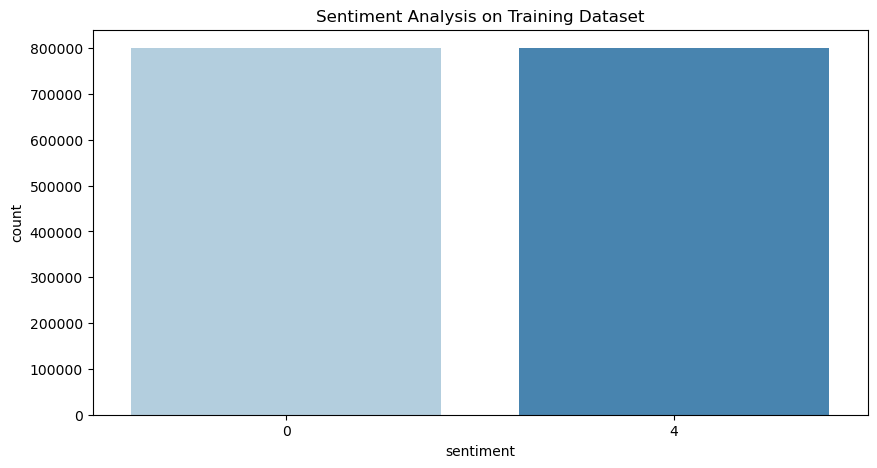

In [24]:
plt.figure(figsize=(10,5))
g = sns.countplot(x='sentiment',data=tweets_train_df, palette='Blues');
g.set_title('Sentiment Analysis on Training Dataset')

plt.show();



In [25]:
#Data balanced.

def get_text_processing(text):
    #Remove any user mention (word starting by "@")
    no_user=[word for word in text.split() if not word.startswith("@")]
    text = ' '.join(no_user)
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [26]:
#tweets_train_df=tweets_train_df.sample(n = 75000)
#tweets_train_df

,sentiment,id,date,flag,user,text
1392041,4,2053377456,Sat Jun 06 04:20:11 PDT 2009,NO_QUERY,hayleystead,drop it like its hot....well at least like bra...
1047578,4,1958056810,Fri May 29 02:30:50 PDT 2009,NO_QUERY,_emmajane_,@liverpoolweath sounds like a plan
61245,0,1686658032,Sun May 03 06:18:19 PDT 2009,NO_QUERY,Blkdrgn2,is home and can now officially focus on her wo...
1238956,4,1993410908,Mon Jun 01 10:20:01 PDT 2009,NO_QUERY,Spankzilla,"@Jessica_Ren I didn't say you said anything, I..."
144691,0,1882023870,Fri May 22 06:04:34 PDT 2009,NO_QUERY,T3mpt4tioN,Found the PERFECT house! I just hope hope hope...
...,...,...,...,...,...,...
1285988,4,2002203697,Tue Jun 02 03:29:30 PDT 2009,NO_QUERY,LACarey5,is super pumped for the first day of finals! ...
555593,0,2204099578,Wed Jun 17 01:19:23 PDT 2009,NO_QUERY,verresnoirs,6pm is taking ages to arrive.
507893,0,2189019242,Mon Jun 15 23:03:43 PDT 2009,NO_QUERY,Zeroness27,@Stephiebutton Whoa! Still no sign of kevin vo...
1478403,4,2066480479,Sun Jun 07 10:36:02 PDT 2009,NO_QUERY,lwmedium,Open your heart and soul and let the love flow...


In [27]:
tweets_train_df['processed_text'] = tweets_train_df['text'].apply(get_text_processing)
tweets_train_df.head()

,sentiment,id,date,flag,user,text,processed_text
1392041,4,2053377456,Sat Jun 06 04:20:11 PDT 2009,NO_QUERY,hayleystead,drop it like its hot....well at least like bra...,drop like hotwell least like bradie ROFL
1047578,4,1958056810,Fri May 29 02:30:50 PDT 2009,NO_QUERY,_emmajane_,@liverpoolweath sounds like a plan,sounds like plan
61245,0,1686658032,Sun May 03 06:18:19 PDT 2009,NO_QUERY,Blkdrgn2,is home and can now officially focus on her wo...,home officially focus workout wo worry classes...
1238956,4,1993410908,Mon Jun 01 10:20:01 PDT 2009,NO_QUERY,Spankzilla,"@Jessica_Ren I didn't say you said anything, I...",didnt say said anything asked worked
144691,0,1882023870,Fri May 22 06:04:34 PDT 2009,NO_QUERY,T3mpt4tioN,Found the PERFECT house! I just hope hope hope...,Found PERFECT house hope hope hope monthly pay...


In [28]:
tweets_train_df = tweets_train_df[['processed_text', 'sentiment']]
tweets_train_df.head()

,processed_text,sentiment
1392041,drop like hotwell least like bradie ROFL,4
1047578,sounds like plan,4
61245,home officially focus workout wo worry classes...,0
1238956,didnt say said anything asked worked,4
144691,Found PERFECT house hope hope hope monthly pay...,0


In [29]:
tweets_train_df['sentiment'].replace([0, 4],['negative', 'positive'],inplace=True)

In [30]:
one_hot = pd.get_dummies(tweets_train_df["sentiment"])
tweets_train_df.drop(['sentiment'],axis=1,inplace=True)
tweets_train_df = pd.concat([tweets_train_df,one_hot],axis=1)
tweets_train_df.head()

,processed_text,negative,positive
1392041,drop like hotwell least like bradie ROFL,0,1
1047578,sounds like plan,0,1
61245,home officially focus workout wo worry classes...,1,0
1238956,didnt say said anything asked worked,0,1
144691,Found PERFECT house hope hope hope monthly pay...,1,0


In [31]:
X = tweets_train_df['processed_text'].values
y = tweets_train_df.drop('processed_text', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [32]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [33]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [34]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

#units=2 as there are 2 categorical values as target
model.add(Dense(units=2, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

In [35]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/100
206/206 [==============================] - 1052s 5s/step - loss: 0.5322 - accuracy: 0.7286 - val_loss: 0.5028 - val_accuracy: 0.7594
Epoch 2/100
206/206 [==============================] - 1030s 5s/step - loss: 0.3142 - accuracy: 0.8694 - val_loss: 0.6012 - val_accuracy: 0.7432
Epoch 3/100
206/206 [==============================] - 1025s 5s/step - loss: 0.1142 - accuracy: 0.9569 - val_loss: 0.9194 - val_accuracy: 0.7244
Epoch 4/100
206/206 [==============================] - 1029s 5s/step - loss: 0.0420 - accuracy: 0.9838 - val_loss: 1.1446 - val_accuracy: 0.7287
Epoch 5/100
206/206 [==============================] - 1028s 5s/step - loss: 0.0258 - accuracy: 0.9889 - val_loss: 1.4632 - val_accuracy: 0.7258
Epoch 6/100
206/206 [==============================] - 1034s 5s/step - loss: 0.0195 - accuracy: 0.9915 - val_loss: 1.4405 - val_accuracy: 0.7269
Epoch 7/100
206/206 [==============================] - 1027s 5s/step - loss: 0.0167 - accuracy: 0.9926 - val_loss: 1.5746 - val_ac

In [36]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

352/352 [==============================] - 106s 300ms/step - loss: 1.5044 - accuracy: 0.7260
Test accuracy: 0.7259555459022522


In [37]:
X_test.shape

(22500, 46475)

In [38]:
def predict_sentiment(df, vect, tfidf, model):
    df['processed_text'] = df['text'].apply(get_text_processing)
    X_tweets=df['processed_text']
    X_tweets = vect.transform(X_tweets)

    X_tweets = tfidf.transform(X_tweets)
    X_tweets = X_tweets.toarray()

    tweets_predicted = model.predict(X_tweets)

    df[["neg_score", "pos_score"]] = tweets_predicted
    df["sentiment"] = np.where(df["neg_score"] > 0.5, 'negative', 'positive')
    return df

In [39]:
tweets_c1=predict_sentiment(tweets_c1_df,vect, tfidf, model)
tweets_c1["Area"]=country1
tweets_c2=predict_sentiment(tweets_c2_df,vect, tfidf, model)
tweets_c2["Area"]='Worldwide'



6/6 [==============================] - 1s 234ms/step


In [40]:
total_tweets=pd.concat([tweets_c1, tweets_c2])

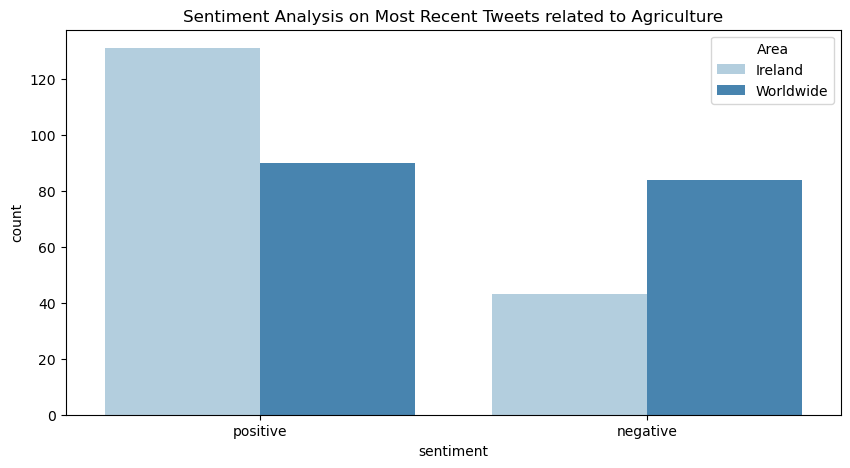

In [41]:
plt.figure(figsize=(10,5))
g = sns.countplot(data=total_tweets, x="sentiment", hue="Area", palette="Blues");
g.set_title('Sentiment Analysis on Most Recent Tweets related to Agriculture')

plt.show();